In [1]:
import mdtraj as md
import numpy as np
from dataclasses import dataclass

PEPTIDE1 = "EA"
PEPTIDE2 = "YR"


@dataclass
class Dimer:
    peptide1: str
    peptide2: str
    _topology: md.Topology = None

    def filename(self, name, suffix):
        return f"../data/{self.peptide1}_{self.peptide2}_{name}.{suffix}"

    @property
    def pdb(self):
        return self.filename("solute", "pdb")
    
    @property
    def coordinate_file(self):
        return self.filename("coord", "npy")
    
    @property
    def energy_file(self):
        return self.filename("energies", "npz")
    
    @property
    def force_file(self):
        return self.filename("force", "npy")
    
    @property
    def equilibration_file(self):
        return self.filename("equilibration", "txt")
    
    @property
    def topology(self):
        if self._topology is None:
            self._topology = md.load(self.pdb).top
        return self._topology
    

    
DIMER = Dimer(PEPTIDE1, PEPTIDE2)

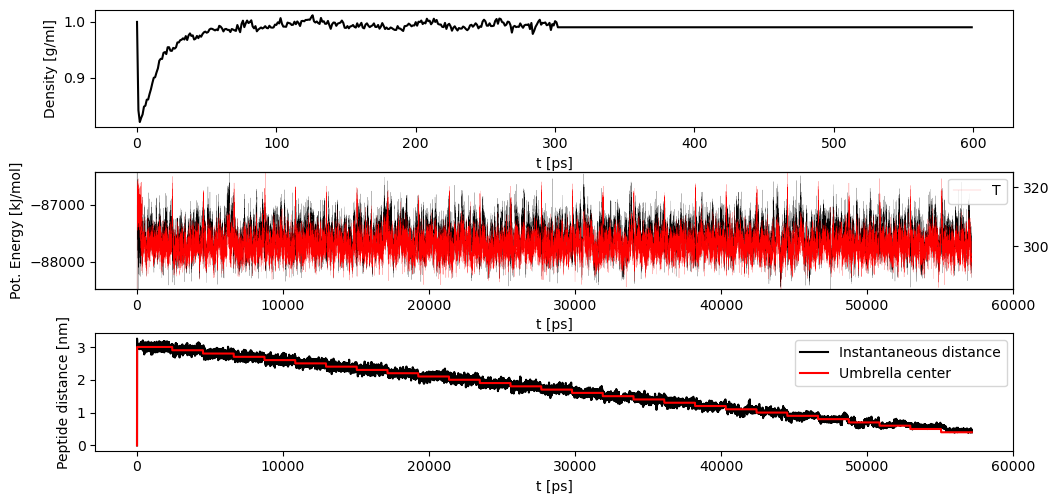

In [13]:
from two_peptides.sanity import EquilibrationStats
from matplotlib import pyplot as plt


def plot_equilibration(dimer):
    fig, axes = plt.subplots(3, figsize=(10, 5))
    fig.tight_layout()

    stats = EquilibrationStats.from_array(np.loadtxt(dimer.equilibration_file))
    axes[0].plot(stats.density[:600], color="black")
    axes[0].set_xlabel("t [ps]")
    axes[0].set_ylabel("Density [g/ml]")

    axes[1].set_ylim(stats.potential_energy[600:].min(), stats.potential_energy[600:].max())
    axes[1].plot(stats.potential_energy, color="black", lw=0.1, label="Pot")
    axes[1].set_xlabel("t [ps]")
    axes[1].set_ylabel("Pot. Energy [kJ/mol]")

    ax2 = axes[1].twinx()
    ax2.set_ylim(stats.temperature[600:].min(), stats.temperature[600:].max())
    ax2.plot(stats.temperature, color="red", lw=0.1, label="T")
    ax2.legend()

    axes[2].plot(stats.d, color="black", label="Instantaneous distance")
    axes[2].plot(stats.d0, color="red", label="Umbrella center")
    axes[2].set_xlabel("t [ps]")
    axes[2].set_ylabel("Peptide distance [nm]")
    axes[2].legend()
    return fig
    
plot_equilibration(DIMER).savefig("equilibration.png", dpi=250)

In [3]:
class AtomisticDimerData:
    def __init__(self, dimer: Dimer):
        self.trajectory = AtomisticDimerData.load_trajectory(dimer)
        self.coordinates = self.trajectory.xyz
        self.forces = np.load(dimer.force_file)
        
    @staticmethod
    def load_trajectory(dimer):
        top = md.load(dimer.pdb).top
        box = np.load(dimer.energy_file)["box"]
        lengths_angles = np.column_stack(md.utils.box_vectors_to_lengths_and_angles(box[:,0], box[:,1], box[:,2]))
        traj = md.Trajectory(
            xyz=np.load(dimer.coordinate_file), 
            unitcell_lengths=lengths_angles[:,:3], 
            unitcell_angles=lengths_angles[:,3:], 
            topology=top
        )
        return traj.image_molecules(anchor_molecules=[{top.atom(i) for i in range(traj.n_atoms) if top.atom(i) in traj.top.chain(0).atoms}])


In [4]:
ATOMISTIC_DATA = AtomisticDimerData(DIMER)

In [19]:
# required downgrading ipywidgets like
# > conda install "ipywidgets>=7.6.0,<8" 

def show_trajectory(atomistic_data):
    import nglview as nv
    traj = atomistic_data.trajectory
    traj = traj.superpose(traj)
    
    w = nv.show_mdtraj(traj)
    w.clear_representations()
    w.add_ball_and_stick(traj.top.select("chainid 1"), radius=0.3)
    w.add_ball_and_stick(traj.top.select("chainid 1"), radius=0.3, color="blue", opacity=0.2)
    w.add_ball_and_stick(traj.top.select("chainid 0"), radius=0.3)
    w.add_ball_and_stick(traj.top.select("chainid 0"), radius=0.3, color="red", opacity=0.2)
    return w

show_trajectory(ATOMISTIC_DATA)

NGLWidget(max_frame=26999)

## import h5py

In [7]:
import two_peptides.meta

def make_slice_mapping(dimer, embedding=two_peptides.meta.embedding):
    embeddings = []
    mapping = []
    for atom in dimer.topology.atoms:
        em = embedding(atom)
        if em > 0:
            embeddings.append(em)
            unit_vector = (np.arange(dimer.topology.n_atoms) == atom.index)
            mapping.append(unit_vector.astype(int))
    return np.row_stack(mapping), embeddings

MAPPING, EMBEDDING = make_slice_mapping(DIMER)

In [8]:

def make_aggregation_mapping(dimer, embedding=two_peptides.meta.embedding):
    for atom in dimer.topology.atoms:
        em = embedding(atom)
        if em > 0:
            ones = [atom.index]
            unit_vector = (np.arange(dimer.topology.n_atoms) == atom.index)
            mapping.append(unit_vector.astype(int))    

In [9]:
MAPPING.shape, ATOMISTIC_DATA.coordinates.shape

((28, 94), (27000, 94, 3))

In [10]:
(MAPPING @ ATOMISTIC_DATA.coordinates).shape

(27000, 28, 3)

In [11]:
ATOMISTIC_DATA.coordinates.shape

(27000, 94, 3)

In [12]:
np.ones((1,3)) @ ATOMISTIC_DATA.coordinates

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 94 is different from 3)